# fast.torch
This should be a template for training self-supervised models using PyTorch and fastai. 

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../../model')
from losses import *
from data import EMSelfPlay
from utils import *
from enum import Enum
from model import DynamicUnet
from custom_transforms import RandomCutOut, ToGrayScale
import numpy as np

# import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from torchvision import models, transforms
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Computer SPECS
gpu_id = 2
num_cores = 4
torch.cuda.set_device(gpu_id)

## DATA

In [3]:
# hyper parameters
bs = 8  # batch size
size = 512  # image size
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/hr/')

In [4]:
config = {'min_n_holes': 10, 'max_n_holes': 15, 
          'min_size': 5, 'max_size': 10}
size = 512
tfms = get_inpainting_transforms(size, config=config)
print(tfms)

{'x': Compose(
    ToGrayScale(3)
    CenterCrop(size=(512, 512))
    RandomCutOut(10, 15, 5, 5)
    ToTensor()
), 'y': Compose(
    ToGrayScale(1)
    CenterCrop(size=(512, 512))
    ToTensor()
)}


## TESTS

In [5]:
inpaint_dataset = EMSelfPlay(data_pth, transforms=tfms)

In [6]:
inpaint_dataloader = DataLoader(inpaint_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

In [12]:
# %debug
x, y = inpaint_dataset[2]

In [13]:
x.shape

torch.Size([3, 512, 512])

In [14]:
y.shape

torch.Size([1, 512, 512])

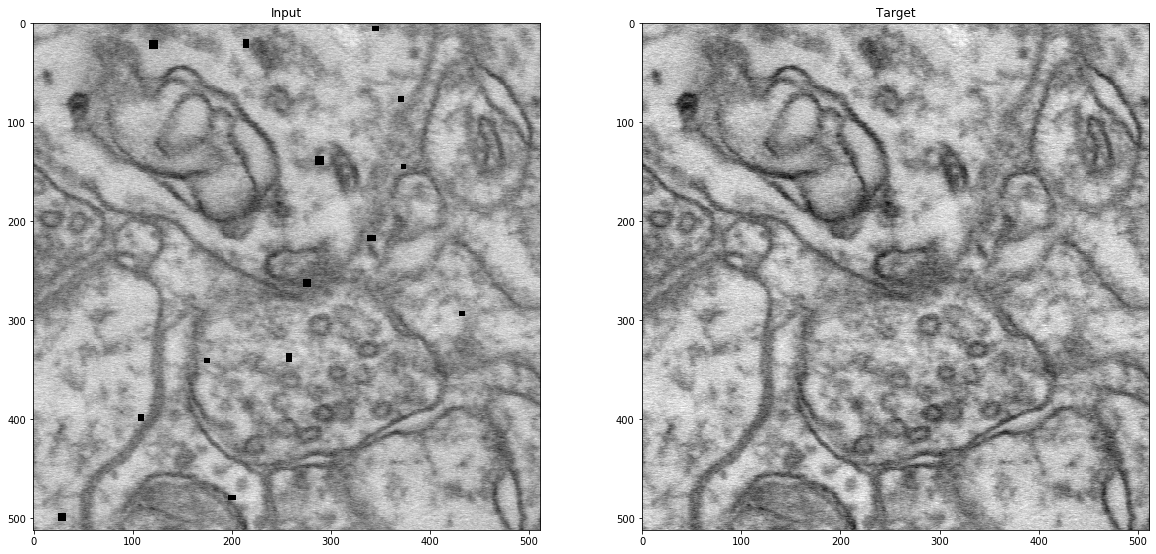

In [15]:
show_sample(inpaint_dataset)

## MODEL

In [7]:
arch = models.resnet34(True)
size = 512
encoder_arch = nn.Sequential(*list(arch.children())[:-2])

nt = Enum('NormType', 'Batch BatchZero Weight Spectral')

model = DynamicUnet(encoder_arch, n_classes=1, 
                    img_size=(size,size), norm_type=nt.Weight)

## Feature loss

In [9]:
torch.save(model.state_dict(), 'tmp.pkl')

In [10]:
critic = copy(model)
critic_state_dict = torch.load('tmp.pkl')
critic.load_state_dict(critic_state_dict)
encoder = critic[0]
feature_maps = find_layers(flatten_model(encoder))
num_feat = len(feature_maps)
feat_loss = FeatureLoss(m_feat=encoder, layer_wgts=[1/num_feat for _ in range(num_feat)])

## TRAINING

In [12]:
loss_function = feat_loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
# %debug
num_epochs = 1
print_every = 10
running_loss = 0.0
model.cuda()
for i in range(num_epochs):
    for j, sample_batch in enumerate(inpaint_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = sample_batch
        inputs = inputs.cuda()
        targets = targets.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        preds = model(inputs)
        loss = loss_function(preds, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if j % (print_every) == 0:
            print(f'Epoch {i+1} Batch {j+1} loss: {running_loss/print_every}')
            running_loss = 0.0

RuntimeError: Given groups=1, weight of size 64 3 7 7, expected input[4, 1, 512, 512] to have 3 channels, but got 1 channels instead

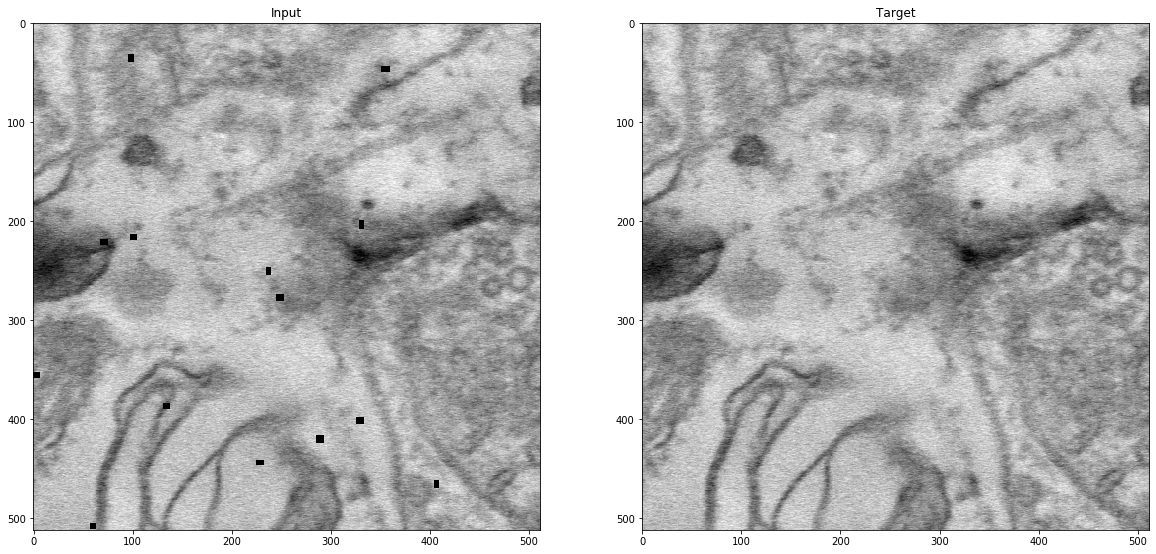

In [27]:
show_sample(inpaint_dataset, idx=32000)

In [28]:
x, y = inpaint_dataset[32000]

In [36]:
model.eval();
pred = model(x.unsqueeze(0).cuda())

In [52]:
pred.permute(3,2,0,1).squeeze()

tensor([[0.4476, 0.5348, 0.5297,  ..., 0.5380, 0.5561, 0.3788],
        [0.5137, 0.6137, 0.5727,  ..., 0.5611, 0.6021, 0.5166],
        [0.7518, 1.0160, 0.7877,  ..., 0.5731, 0.5893, 0.6153],
        ...,
        [0.6684, 0.9183, 0.7371,  ..., 0.4335, 0.3497, 0.3440],
        [0.5774, 0.8920, 0.6092,  ..., 0.4359, 0.4312, 0.3508],
        [0.4017, 0.6966, 0.5627,  ..., 0.4107, 0.4181, 0.2655]],
       device='cuda:1', grad_fn=<SqueezeBackward0>)

In [46]:
y.shape

torch.Size([1, 512, 512])

In [53]:
def show_result(x, y, pred, figsize=(20,20)):
    """A helper function to visualize data samples."""
    f, axarr = plt.subplots(1,3, figsize=figsize)  # create visualizations
    axarr[0].imshow(x.permute(1,2,0)) # visualize image tensor
    axarr[0].set_title('Input')
    axarr[1].imshow(y.permute(1,2,0).squeeze(), cmap=plt.cm.gray) # visualize image tensor
    axarr[1].set_title('Target')
    axarr[2].imshow(pred.permute(3,2,0,1).squeeze(), cmap=plt.cm.gray) # visualize image tensor
    axarr[2].set_title('Prediction')

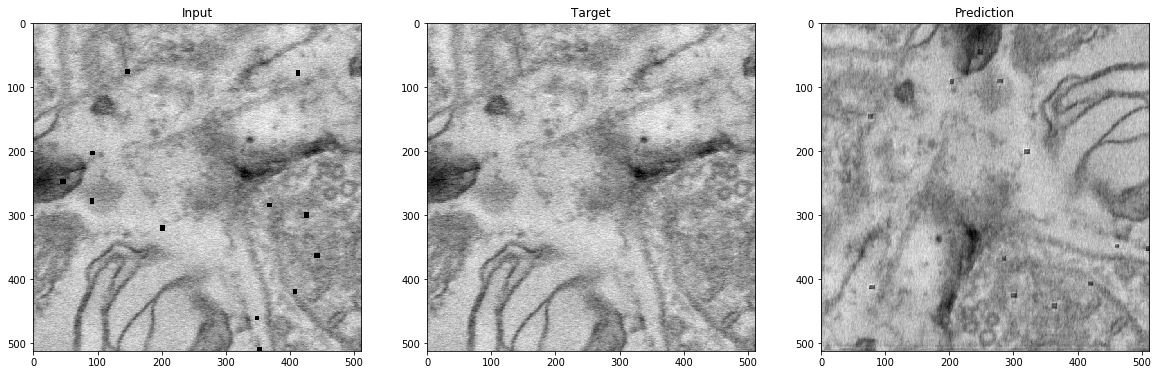

In [54]:
show_result(x, y, pred)